# Hand Gesture Recognition với Neural Network

Notebook này hướng dẫn xây dựng và training một neural network model để nhận dạng cử chỉ tay sử dụng hand landmarks từ MediaPipe.

## Mục tiêu:
- Load và khám phá dataset hand gesture 
- Tiền xử lý dữ liệu hand landmarks
- Xây dựng neural network architecture
- Training model với TensorFlow/Keras
- Đánh giá hiệu suất model
- Convert sang TensorFlow Lite để deploy
- Test inference với model đã train

## 1. Import Required Libraries

In [13]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.19.0
Pandas version: 2.3.1
NumPy version: 1.26.4


## 2. Load và Explore Dataset

In [14]:
# Đường dẫn đến dataset
dataset_path = 'dataset/hand_gestures_dataset.csv'

# Load dataset
print("Loading dataset...")
df = pd.read_csv(dataset_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nGesture distribution:")
print(df['gesture_name'].value_counts())

print("\nHand type distribution:")
print(df['hand_0_type'].value_counts())

print("\nNumber of hands distribution:")
print(df['num_hands'].value_counts())

Loading dataset...
Dataset shape: (959, 90)
Columns: 90

First few rows:
                timestamp  class_id gesture_name  num_hands hand_0_type  \
0  20250807_161032_401448         2          two          1        Left   
1  20250807_161033_963409         2          two          1        Left   
2  20250807_161034_845662         2          two          2        Left   
3  20250807_161035_492472         2          two          1        Left   
4  20250807_161035_995513         2          two          1        Left   

   hand_0_landmark_0_x  hand_0_landmark_0_y  hand_0_landmark_1_x  \
0                  141                  418                  189   
1                  173                  455                  220   
2                  288                  417                  326   
3                  375                  464                  433   
4                  425                  456                  481   

   hand_0_landmark_1_y  hand_0_landmark_2_x  ...  hand_1_landmark_1

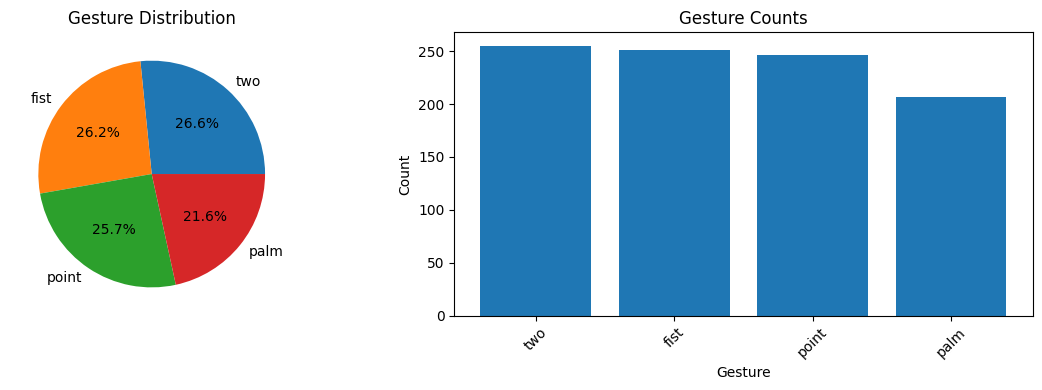


Dataset Summary:
Total samples: 959
Number of gestures: 4
Gesture classes: ['two', 'fist', 'point', 'palm']
Missing values: 39775


In [15]:
# Visualize gesture distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
gesture_counts = df['gesture_name'].value_counts()
plt.pie(gesture_counts.values, labels=gesture_counts.index, autopct='%1.1f%%')
plt.title('Gesture Distribution')

plt.subplot(1, 2, 2)
plt.bar(gesture_counts.index, gesture_counts.values)
plt.title('Gesture Counts')
plt.xlabel('Gesture')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nDataset Summary:")
print(f"Total samples: {len(df)}")
print(f"Number of gestures: {df['gesture_name'].nunique()}")
print(f"Gesture classes: {list(df['gesture_name'].unique())}")
print(f"Missing values: {df.isnull().sum().sum()}")

## 3. Data Preprocessing

Xử lý dữ liệu để chuẩn bị cho việc training model. Chúng ta sẽ:
- Lọc ra chỉ các sample có 1 tay (đơn giản hóa)
- Extract tọa độ x,y của 21 landmarks
- Normalize dữ liệu
- Encode labels

In [16]:
# Filter data - chỉ lấy samples có 1 tay để đơn giản
df_filtered = df[df['num_hands'] == 1].copy()
print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Remaining gestures: {df_filtered['gesture_name'].value_counts()}")

# Tạo function để extract hand landmarks
def extract_hand_landmarks(row):
    """Extract x,y coordinates of 21 hand landmarks"""
    landmarks = []
    
    # Extract 21 landmarks (0-20) for hand_0
    for i in range(21):
        x_col = f'hand_0_landmark_{i}_x'
        y_col = f'hand_0_landmark_{i}_y'
        
        if x_col in row and y_col in row:
            landmarks.extend([row[x_col], row[y_col]])
        else:
            # Fill missing landmarks with 0
            landmarks.extend([0.0, 0.0])
    
    return np.array(landmarks)

# Extract features (42 features: 21 landmarks × 2 coordinates)
print("Extracting hand landmarks...")
X_data = []
y_data = []

for idx, row in df_filtered.iterrows():
    landmarks = extract_hand_landmarks(row)
    if len(landmarks) == 42:  # Ensure we have all 21 landmarks
        X_data.append(landmarks)
        y_data.append(row['gesture_name'])

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Feature matrix shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")
print(f"Feature range - min: {X_data.min():.2f}, max: {X_data.max():.2f}")

Filtered dataset shape: (925, 90)
Remaining gestures: gesture_name
fist     245
point    239
two      234
palm     207
Name: count, dtype: int64
Extracting hand landmarks...
Feature matrix shape: (925, 42)
Labels shape: (925,)
Feature range - min: -32.00, max: 691.00


## 4. Feature Engineering và Normalization

Normalized feature range - min: 0.00, max: 1.00
Original labels: ['fist' 'palm' 'point' 'two']
Encoded labels: [0 1 2 3]
Number of classes: 4
Scaler and label encoder saved!


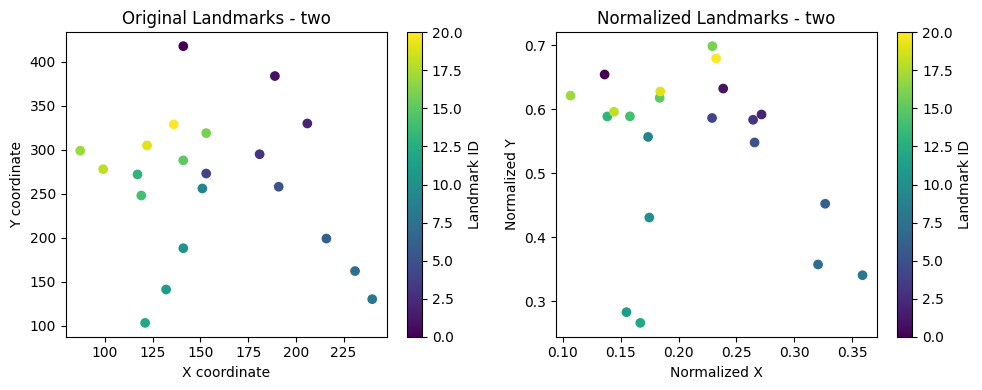

In [17]:
# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_data)

print(f"Normalized feature range - min: {X_normalized.min():.2f}, max: {X_normalized.max():.2f}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

print(f"Original labels: {label_encoder.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Save scaler and label encoder for later use
os.makedirs('model/neural_network', exist_ok=True)

with open('model/neural_network/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model/neural_network/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Scaler and label encoder saved!")

# Visualize a sample of landmarks
plt.figure(figsize=(10, 4))

# Plot original vs normalized features for first sample
sample_idx = 0
original_landmarks = X_data[sample_idx].reshape(21, 2)
normalized_landmarks = X_normalized[sample_idx].reshape(21, 2)

plt.subplot(1, 2, 1)
plt.scatter(original_landmarks[:, 0], original_landmarks[:, 1], c=range(21), cmap='viridis')
plt.title(f'Original Landmarks - {y_data[sample_idx]}')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.colorbar(label='Landmark ID')

plt.subplot(1, 2, 2)
plt.scatter(normalized_landmarks[:, 0], normalized_landmarks[:, 1], c=range(21), cmap='viridis')
plt.title(f'Normalized Landmarks - {y_data[sample_idx]}')
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.colorbar(label='Landmark ID')

plt.tight_layout()
plt.show()

## 5. Train-Test Split

In [18]:
# Split data into train and test sets
try:
    # Try stratified split first
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_encoded, 
        test_size=0.25, 
        random_state=RANDOM_SEED,
        stratify=y_encoded
    )
    print("Using stratified split")
except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Using simple random split")
    # Fallback to simple random split
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_encoded, 
        test_size=0.25, 
        random_state=RANDOM_SEED
    )

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check class distribution in train and test sets
print("\nClass distribution in training set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for cls, count in zip(train_unique, train_counts):
    gesture_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {gesture_name} (class {cls}): {count} samples")

print("\nClass distribution in test set:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for cls, count in zip(test_unique, test_counts):
    gesture_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {gesture_name} (class {cls}): {count} samples")

Using stratified split
Training set shape: (693, 42)
Test set shape: (232, 42)
Training labels shape: (693,)
Test labels shape: (232,)

Class distribution in training set:
  fist (class 0): 184 samples
  palm (class 1): 155 samples
  point (class 2): 179 samples
  two (class 3): 175 samples

Class distribution in test set:
  fist (class 0): 61 samples
  palm (class 1): 52 samples
  point (class 2): 60 samples
  two (class 3): 59 samples


## 6. Model Architecture Setup

Tạo neural network architecture dựa trên project mẫu, được điều chỉnh cho dataset của chúng ta.

In [19]:
# Define model parameters
INPUT_SIZE = 42  # 21 landmarks × 2 coordinates
NUM_CLASSES = len(label_encoder.classes_)

print(f"Input size: {INPUT_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {label_encoder.classes_}")

# Build neural network model (based on the sample project)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((INPUT_SIZE,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Display model architecture
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='model/neural_network/model_architecture.png',
    show_shapes=True, 
    show_layer_names=True,
    dpi=96
)

print("Model architecture saved as model_architecture.png")

Input size: 42
Number of classes: 4
Classes: ['fist' 'palm' 'point' 'two']


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114 (4.35 KB)

 Trainable params: 1,114 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture saved as model_architecture.png


## 7. Model Training

In [20]:
# Define paths for saving model
model_save_path = 'model/neural_network/hand_gesture_model.h5'
checkpoint_path = 'model/neural_network/checkpoints/hand_gesture_model.h5'

# Create directories
os.makedirs('model/neural_network/checkpoints', exist_ok=True)

# Define callbacks
callbacks = [
    # Model checkpoint - save best model
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    # Early stopping - stop training if no improvement
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        verbose=1,
        restore_best_weights=True
    ),
    # Reduce learning rate on plateau
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        verbose=1,
        min_lr=1e-7
    )
]

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("Starting training...")

Model compiled successfully!
Starting training...


Epoch 1/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 12s 614ms/step - accuracy: 0.2500 - loss: 1.4397
Epoch 1: val_accuracy improved from None to 0.37500, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2915 - loss: 1.3977 - val_accuracy: 0.3750 - val_loss: 1.3686 - learning_rate: 0.0010
Epoch 2/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3438 - loss: 1.3765
Epoch 2: val_accuracy improved from 0.37500 to 0.47414, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2828 - loss: 1.3784 - val_accuracy: 0.4741 - val_loss: 1.3410 - learning_rate: 0.0010
Epoch 3/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2188 - loss: 1.4052
Epoch 3: val_accuracy improved from 0.47414 to 0.59483, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3117 - loss: 1.3713 - val_accuracy: 0.5948 - val_loss: 1.3279 - learning_rate: 0.0010
Epoch 4/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3125 - loss: 1.3557
Epoch 4: val_accuracy did not improve from 0.59483
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3175 - loss: 1.3480 - val_accuracy: 0.5474 - val_loss: 1.3177 - learning_rate: 0.0010
Epoch 5/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4375 - loss: 1.3101
Epoch 5: val_accuracy did not improve from 0.59483
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3319 - loss: 1.3506 - val_accuracy: 0.5431 - val_loss: 1.3028 - learning_rate: 0.0010
Epoch 6/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3125 - loss: 1.3468
Epoch 6: val_accuracy did not improve from 0.59483
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3795 - loss: 1.3256 - val_accuracy: 0.4957 - val_loss: 1.2807 - learning_rate: 0.0010
Epoch 7/1000
 1/22 ━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4055 - loss: 1.2992 - val_accuracy: 0.6034 - val_loss: 1.2360 - learning_rate: 0.0010
Epoch 9/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3125 - loss: 1.3328
Epoch 9: val_accuracy improved from 0.60345 to 0.73276, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3694 - loss: 1.3190 - val_accuracy: 0.7328 - val_loss: 1.1959 - learning_rate: 0.0010
Epoch 10/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5625 - loss: 1.2288
Epoch 10: val_accuracy improved from 0.73276 to 0.74138, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4517 - loss: 1.2566 - val_accuracy: 0.7414 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 11/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4688 - loss: 1.2626
Epoch 11: val_accuracy improved from 0.74138 to 0.77586, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4358 - loss: 1.2566 - val_accuracy: 0.7759 - val_loss: 1.1385 - learning_rate: 0.0010
Epoch 12/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5000 - loss: 1.2279
Epoch 12: val_accuracy did not improve from 0.77586
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4589 - loss: 1.2443 - val_accuracy: 0.7543 - val_loss: 1.1197 - learning_rate: 0.0010
Epoch 13/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6562 - loss: 1.1813
Epoch 13: val_accuracy did not improve from 0.77586
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4618 - loss: 1.2322 - val_accuracy: 0.7629 - val_loss: 1.0963 - learning_rate: 0.0010
Epoch 14/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3750 - loss: 1.3666
Epoch 14: val_accuracy improved from 0.77586 to 0.81466, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4618 - loss: 1.2190 - val_accuracy: 0.8147 - val_loss: 1.0467 - learning_rate: 0.0010
Epoch 15/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5312 - loss: 1.1550
Epoch 15: val_accuracy improved from 0.81466 to 0.84483, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4848 - loss: 1.1775 - val_accuracy: 0.8448 - val_loss: 1.0125 - learning_rate: 0.0010
Epoch 16/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 1.2518
Epoch 16: val_accuracy did not improve from 0.84483
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4719 - loss: 1.1833 - val_accuracy: 0.8147 - val_loss: 0.9841 - learning_rate: 0.0010
Epoch 17/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5312 - loss: 1.1919
Epoch 17: val_accuracy did not improve from 0.84483
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5022 - loss: 1.1423 - val_accuracy: 0.8276 - val_loss: 0.9498 - learning_rate: 0.0010
Epoch 18/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4688 - loss: 1.2075
Epoch 18: val_accuracy did not improve from 0.84483
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5079 - loss: 1.1225 - val_accuracy: 0.8319 - val_loss: 0.9122 - learning_rate: 0.0010
Epoch 19/1000
 1/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4964 - loss: 1.1264 - val_accuracy: 0.8707 - val_loss: 0.8564 - learning_rate: 0.0010
Epoch 21/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - loss: 0.9916
Epoch 21: val_accuracy did not improve from 0.87069
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5325 - loss: 1.0964 - val_accuracy: 0.8534 - val_loss: 0.8393 - learning_rate: 0.0010
Epoch 22/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5938 - loss: 0.9481
Epoch 22: val_accuracy improved from 0.87069 to 0.87500, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5281 - loss: 1.0804 - val_accuracy: 0.8750 - val_loss: 0.8139 - learning_rate: 0.0010
Epoch 23/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6875 - loss: 1.0518
Epoch 23: val_accuracy did not improve from 0.87500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5397 - loss: 1.0861 - val_accuracy: 0.8664 - val_loss: 0.8001 - learning_rate: 0.0010
Epoch 24/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5938 - loss: 1.0455
Epoch 24: val_accuracy did not improve from 0.87500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5195 - loss: 1.0959 - val_accuracy: 0.8147 - val_loss: 0.8003 - learning_rate: 0.0010
Epoch 25/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5625 - loss: 1.0386
Epoch 25: val_accuracy did not improve from 0.87500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5368 - loss: 1.0608 - val_accuracy: 0.8578 - val_loss: 0.7752 - learning_rate: 0.0010
Epoch 26/1000
 1/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5671 - loss: 1.0290 - val_accuracy: 0.8879 - val_loss: 0.7198 - learning_rate: 0.0010
Epoch 29/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5938 - loss: 0.9677
Epoch 29: val_accuracy did not improve from 0.88793
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5685 - loss: 1.0290 - val_accuracy: 0.8664 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 30/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6562 - loss: 1.0452
Epoch 30: val_accuracy did not improve from 0.88793
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 0.9993 - val_accuracy: 0.8491 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 31/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - loss: 0.8393
Epoch 31: val_accuracy did not improve from 0.88793
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5801 - loss: 0.9895 - val_accuracy: 0.8233 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 32/1000
 1/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5916 - loss: 0.9735 - val_accuracy: 0.8966 - val_loss: 0.6265 - learning_rate: 0.0010
Epoch 41/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - loss: 0.8030
Epoch 41: val_accuracy did not improve from 0.89655
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5902 - loss: 0.9371 - val_accuracy: 0.8664 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 42/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5938 - loss: 0.8868
Epoch 42: val_accuracy did not improve from 0.89655
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5974 - loss: 0.9682 - val_accuracy: 0.8879 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 43/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5938 - loss: 0.8529
Epoch 43: val_accuracy did not improve from 0.89655
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6147 - loss: 0.9545 - val_accuracy: 0.8879 - val_loss: 0.6331 - learning_rate: 0.0010
Epoch 44/1000
 1/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6306 - loss: 0.9568 - val_accuracy: 0.9095 - val_loss: 0.6312 - learning_rate: 0.0010
Epoch 45/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5938 - loss: 0.9318
Epoch 45: val_accuracy did not improve from 0.90948
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6291 - loss: 0.9187 - val_accuracy: 0.8922 - val_loss: 0.6029 - learning_rate: 0.0010
Epoch 46/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6250 - loss: 1.0189
Epoch 46: val_accuracy did not improve from 0.90948
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5945 - loss: 0.9404 - val_accuracy: 0.8879 - val_loss: 0.5762 - learning_rate: 0.0010
Epoch 47/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7812 - loss: 0.6202
Epoch 47: val_accuracy did not improve from 0.90948
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6190 - loss: 0.9534 - val_accuracy: 0.8879 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 48/1000
 1/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6696 - loss: 0.8582 - val_accuracy: 0.9181 - val_loss: 0.5513 - learning_rate: 0.0010
Epoch 53/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6562 - loss: 0.7715
Epoch 53: val_accuracy did not improve from 0.91810
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6248 - loss: 0.8998 - val_accuracy: 0.9138 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 54/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6009
Epoch 54: val_accuracy improved from 0.91810 to 0.92672, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6248 - loss: 0.8473 - val_accuracy: 0.9267 - val_loss: 0.5161 - learning_rate: 0.0010
Epoch 55/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7188 - loss: 0.8551
Epoch 55: val_accuracy did not improve from 0.92672
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6494 - loss: 0.8775 - val_accuracy: 0.9095 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 56/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6250 - loss: 0.8935
Epoch 56: val_accuracy did not improve from 0.92672
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9207 - val_accuracy: 0.9095 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 57/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6875 - loss: 0.7242
Epoch 57: val_accuracy did not improve from 0.92672
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6566 - loss: 0.8500 - val_accuracy: 0.9138 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 58/1000
 1/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6263 - loss: 0.8543 - val_accuracy: 0.9397 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 62/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8438 - loss: 0.5663
Epoch 62: val_accuracy did not improve from 0.93966
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6638 - loss: 0.8819 - val_accuracy: 0.9267 - val_loss: 0.5039 - learning_rate: 0.0010
Epoch 63/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.8360
Epoch 63: val_accuracy did not improve from 0.93966
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6335 - loss: 0.8729 - val_accuracy: 0.9224 - val_loss: 0.5017 - learning_rate: 0.0010
Epoch 64/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7188 - loss: 0.8786
Epoch 64: val_accuracy did not improve from 0.93966
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6551 - loss: 0.8992 - val_accuracy: 0.9310 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 65/1000
 1/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6753 - loss: 0.8523 - val_accuracy: 0.9440 - val_loss: 0.5203 - learning_rate: 0.0010
Epoch 74/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5938 - loss: 0.9351
Epoch 74: val_accuracy improved from 0.94397 to 0.94828, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6479 - loss: 0.8686 - val_accuracy: 0.9483 - val_loss: 0.5286 - learning_rate: 0.0010
Epoch 75/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7188 - loss: 0.5946
Epoch 75: val_accuracy did not improve from 0.94828
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6753 - loss: 0.8369 - val_accuracy: 0.9310 - val_loss: 0.5006 - learning_rate: 0.0010
Epoch 76/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7812 - loss: 0.6516
Epoch 76: val_accuracy improved from 0.94828 to 0.95259, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6306 - loss: 0.8668 - val_accuracy: 0.9526 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 77/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6562 - loss: 0.8698
Epoch 77: val_accuracy did not improve from 0.95259

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6407 - loss: 0.8664 - val_accuracy: 0.9397 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 78/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.8030
Epoch 78: val_accuracy did not improve from 0.95259
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6364 - loss: 0.8647 - val_accuracy: 0.9310 - val_loss: 0.5218 - learning_rate: 5.0000e-04
Epoch 79/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6875 - loss: 0.7668
Epoch 79: val_accuracy did not improve from 0.95259
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6522 - loss: 0.8451 - val_ac

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6941 - loss: 0.7967 - val_accuracy: 0.9569 - val_loss: 0.4794 - learning_rate: 5.0000e-04
Epoch 84/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.5716
Epoch 84: val_accuracy did not improve from 0.95690
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6450 - loss: 0.8679 - val_accuracy: 0.9526 - val_loss: 0.4774 - learning_rate: 5.0000e-04
Epoch 85/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7188 - loss: 0.7169
Epoch 85: val_accuracy did not improve from 0.95690
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6595 - loss: 0.8339 - val_accuracy: 0.9483 - val_loss: 0.4878 - learning_rate: 5.0000e-04
Epoch 86/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - loss: 0.7810
Epoch 86: val_accuracy did not improve from 0.95690
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6580 - loss: 0.8221 - val_accuracy: 0.9483 - val_loss: 0.4958 - learning_rate: 5.0000e-04
Epoch 87

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6955 - loss: 0.7737 - val_accuracy: 0.9612 - val_loss: 0.4559 - learning_rate: 5.0000e-04
Epoch 99/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7812 - loss: 0.6313
Epoch 99: val_accuracy did not improve from 0.96121
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6739 - loss: 0.8016 - val_accuracy: 0.9569 - val_loss: 0.4560 - learning_rate: 5.0000e-04
Epoch 100/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6833
Epoch 100: val_accuracy did not improve from 0.96121
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6984 - loss: 0.7973 - val_accuracy: 0.9526 - val_loss: 0.4451 - learning_rate: 5.0000e-04
Epoch 101/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8125 - loss: 0.6300
Epoch 101: val_accuracy improved from 0.96121 to 0.96552, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6652 - loss: 0.8182 - val_accuracy: 0.9655 - val_loss: 0.4447 - learning_rate: 5.0000e-04
Epoch 102/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8438 - loss: 0.6115
Epoch 102: val_accuracy did not improve from 0.96552
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6652 - loss: 0.8175 - val_accuracy: 0.9526 - val_loss: 0.4495 - learning_rate: 5.0000e-04
Epoch 103/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8438 - loss: 0.6477
Epoch 103: val_accuracy did not improve from 0.96552
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6883 - loss: 0.7851 - val_accuracy: 0.9569 - val_loss: 0.4416 - learning_rate: 5.0000e-04
Epoch 104/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - loss: 0.5368
Epoch 104: val_accuracy did not improve from 0.96552
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6782 - loss: 0.8307 - val_accuracy: 0.9569 - val_loss: 0.4511 - learning_rate: 5.0000e-04
Ep

Model saved to model/neural_network/hand_gesture_model.h5


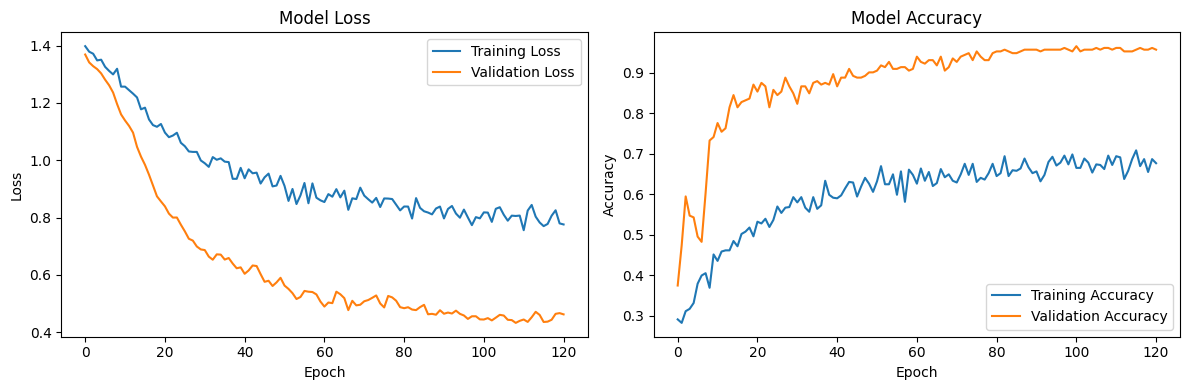


Final Training Results:
Training Loss: 0.7761
Training Accuracy: 0.6768
Validation Loss: 0.4626
Validation Accuracy: 0.9569


In [21]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=min(32, len(X_train)),  # Adjust batch size for small datasets
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(model_save_path, include_optimizer=False)
print(f"Model saved to {model_save_path}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('model/neural_network/training_history.png')
plt.show()

# Print final training results
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Results:")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")

## 8. Model Evaluation

Test Loss: 0.4447
Test Accuracy: 0.9655
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Detailed Test Results:
Accuracy: 0.9655


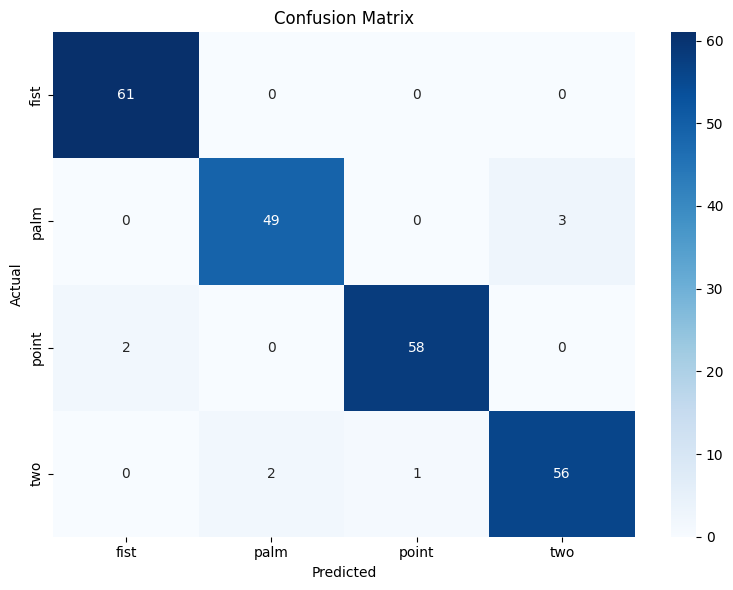


Classification Report:
              precision    recall  f1-score   support

        fist       0.97      1.00      0.98        61
        palm       0.96      0.94      0.95        52
       point       0.98      0.97      0.97        60
         two       0.95      0.95      0.95        59

    accuracy                           0.97       232
   macro avg       0.97      0.96      0.96       232
weighted avg       0.97      0.97      0.97       232


Per-class Results:
fist: Precision=0.968, Recall=1.000, F1=0.984, Support=61.0
palm: Precision=0.961, Recall=0.942, F1=0.951, Support=52.0
point: Precision=0.983, Recall=0.967, F1=0.975, Support=60.0
two: Precision=0.949, Recall=0.949, F1=0.949, Support=59.0

Sample Predictions:
Sample 1: True=two, Predicted=two, Confidence=0.366
  Class probabilities:
    fist: 0.143
    palm: 0.257
    point: 0.233
    two: 0.366

Sample 2: True=palm, Predicted=palm, Confidence=0.701
  Class probabilities:
    fist: 0.011
    palm: 0.701
    point: 

In [22]:
# Load best model for evaluation
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nDetailed Test Results:")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('model/neural_network/confusion_matrix.png')
    plt.show()
    
    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)

# Classification Report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, 
                             target_names=label_encoder.classes_,
                             output_dict=True)
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_))

# Per-class accuracy
print("\nPer-class Results:")
for i, class_name in enumerate(label_encoder.classes_):
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")

# Sample predictions with confidence scores
print("\nSample Predictions:")
for i in range(min(5, len(X_test))):
    true_label = label_encoder.inverse_transform([y_test[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    confidence = np.max(y_pred_proba[i])
    
    print(f"Sample {i+1}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.3f}")
    
    # Show confidence for all classes
    print("  Class probabilities:")
    for j, class_name in enumerate(label_encoder.classes_):
        prob = y_pred_proba[i][j]
        print(f"    {class_name}: {prob:.3f}")
    print()

## 9. Model Optimization và TensorFlow Lite Conversion

Convert model sang TensorFlow Lite để deploy trên mobile hoặc embedded devices.

In [23]:
# Save model without optimizer for inference
inference_model_path = 'model/neural_network/hand_gesture_inference.h5'
best_model.save(inference_model_path, include_optimizer=False)

# Convert to TensorFlow Lite
tflite_model_path = 'model/neural_network/hand_gesture_model.tflite'

print("Converting model to TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Apply optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {tflite_model_path}")

# Compare model sizes
import os

original_size = os.path.getsize(model_save_path)
tflite_size = os.path.getsize(tflite_model_path)

print(f"\nModel Size Comparison:")
print(f"Original Keras model: {original_size/1024:.2f} KB")
print(f"TensorFlow Lite model: {tflite_size/1024:.2f} KB")
print(f"Size reduction: {((original_size - tflite_size) / original_size) * 100:.1f}%")

# Create a representative dataset for quantization (optional)
def representative_dataset():
    for i in range(min(100, len(X_train))):
        yield [X_train[i:i+1].astype(np.float32)]

# Convert with quantization
print("\nConverting with quantization...")
converter_quantized = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter_quantized.optimizations = [tf.lite.Optimize.DEFAULT]
converter_quantized.representative_dataset = representative_dataset
converter_quantized.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quantized.inference_input_type = tf.int8
converter_quantized.inference_output_type = tf.int8

tflite_quantized_model = converter_quantized.convert()

# Save quantized model
tflite_quantized_path = 'model/neural_network/hand_gesture_model_quantized.tflite'
with open(tflite_quantized_path, 'wb') as f:
    f.write(tflite_quantized_model)

quantized_size = os.path.getsize(tflite_quantized_path)
print(f"Quantized TensorFlow Lite model: {quantized_size/1024:.2f} KB")
print(f"Additional size reduction: {((tflite_size - quantized_size) / tflite_size) * 100:.1f}%")

Converting model to TensorFlow Lite...
INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpnj6rmxa8\assets


INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpnj6rmxa8\assets


Saved artifact at 'C:\Users\Dell\AppData\Local\Temp\tmpnj6rmxa8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2785662659728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662653584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662655120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662657424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662657040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662659536: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model saved to model/neural_network/hand_gesture_model.tflite

Model Size Comparison:
Original Keras model: 25.48 KB
TensorFlow Lite model: 6.40 KB
Size reduction: 74.9%

Converting with quantization...
INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\t

INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmphce6vojz\assets


Saved artifact at 'C:\Users\Dell\AppData\Local\Temp\tmphce6vojz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2785662659728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662653584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662655120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662657424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662657040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2785662659536: TensorSpec(shape=(), dtype=tf.resource, name=None)
Quantized TensorFlow Lite model: 4.40 KB
Additional size reduction: 31.3%


## 10. Inference Testing

Test các model đã convert với sample data để đảm bảo hoạt động chính xác.

In [24]:
# Test TensorFlow Lite model
def test_tflite_model(model_path, test_sample):
    """Test TensorFlow Lite model inference"""
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], test_sample)
    
    # Run inference
    interpreter.invoke()
    
    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Test with first test sample
test_sample = X_test[0:1].astype(np.float32)

print("Testing inference on different model formats...")
print(f"Test sample shape: {test_sample.shape}")
print(f"True label: {label_encoder.inverse_transform([y_test[0]])[0]}")

# Original Keras model prediction
keras_pred = best_model.predict(test_sample, verbose=0)
keras_class = np.argmax(keras_pred)
keras_confidence = np.max(keras_pred)

print(f"\nKeras model:")
print(f"  Predicted class: {label_encoder.inverse_transform([keras_class])[0]}")
print(f"  Confidence: {keras_confidence:.4f}")
print(f"  Raw predictions: {keras_pred[0]}")

# TensorFlow Lite model prediction
tflite_pred = test_tflite_model(tflite_model_path, test_sample)
tflite_class = np.argmax(tflite_pred)
tflite_confidence = np.max(tflite_pred)

print(f"\nTensorFlow Lite model:")
print(f"  Predicted class: {label_encoder.inverse_transform([tflite_class])[0]}")
print(f"  Confidence: {tflite_confidence:.4f}")
print(f"  Raw predictions: {tflite_pred[0]}")

# Check if predictions match
predictions_match = np.allclose(keras_pred, tflite_pred, atol=1e-5)
print(f"\nPredictions match: {predictions_match}")
print(f"Max difference: {np.max(np.abs(keras_pred - tflite_pred)):.6f}")

# Benchmark inference speed
import time

def benchmark_model(model_func, test_data, num_runs=100):
    """Benchmark model inference speed"""
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = model_func(test_data)
        times.append(time.time() - start_time)
    
    return np.mean(times), np.std(times)

# Keras model benchmark
def keras_inference(data):
    return best_model.predict(data, verbose=0)

# TensorFlow Lite model benchmark
def tflite_inference(data):
    return test_tflite_model(tflite_model_path, data)

print("\nBenchmarking inference speed (100 runs):")

keras_time, keras_std = benchmark_model(keras_inference, test_sample)
print(f"Keras model: {keras_time*1000:.2f} ± {keras_std*1000:.2f} ms")

tflite_time, tflite_std = benchmark_model(tflite_inference, test_sample)
print(f"TensorFlow Lite: {tflite_time*1000:.2f} ± {tflite_std*1000:.2f} ms")

speedup = keras_time / tflite_time
print(f"Speedup: {speedup:.2f}x")

# Test all test samples
print("\nTesting all test samples...")
correct_keras = 0
correct_tflite = 0

for i in range(len(X_test)):
    sample = X_test[i:i+1].astype(np.float32)
    true_label = y_test[i]
    
    # Keras prediction
    keras_pred = best_model.predict(sample, verbose=0)
    keras_class = np.argmax(keras_pred)
    
    # TFLite prediction  
    tflite_pred = test_tflite_model(tflite_model_path, sample)
    tflite_class = np.argmax(tflite_pred)
    
    if keras_class == true_label:
        correct_keras += 1
    if tflite_class == true_label:
        correct_tflite += 1

keras_accuracy = correct_keras / len(X_test)
tflite_accuracy = correct_tflite / len(X_test)

print(f"Keras model accuracy: {keras_accuracy:.4f}")
print(f"TensorFlow Lite accuracy: {tflite_accuracy:.4f}")
print(f"Accuracy difference: {abs(keras_accuracy - tflite_accuracy):.6f}")

Testing inference on different model formats...
Test sample shape: (1, 42)
True label: two

Keras model:
  Predicted class: two
  Confidence: 0.3664
  Raw predictions: [0.14339282 0.25677356 0.2334285  0.36640513]

TensorFlow Lite model:
  Predicted class: two
  Confidence: 0.3664
  Raw predictions: [0.14339285 0.25677353 0.2334285  0.36640513]

Predictions match: True
Max difference: 0.000000

Benchmarking inference speed (100 runs):
Keras model: 51.62 ± 2.77 ms
TensorFlow Lite: 0.17 ± 0.38 ms
Speedup: 299.30x

Testing all test samples...
Keras model accuracy: 0.9655
TensorFlow Lite accuracy: 0.9655
Accuracy difference: 0.000000
